In [1]:
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from sklearn import preprocessing
np.random.seed(2017)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
train_feature_data = pd.read_csv("train.csv").as_matrix()
test_feature_data = pd.read_csv("test.csv").as_matrix()

X_feature = np.empty((train_feature_data.shape[0], 64, 64, 3))

for id in range(train_feature_data.shape[0]):
    
    feature_1 = train_feature_data[id, 2:66]
    feature_2 = train_feature_data[id, 66:130]
    feature_3 = train_feature_data[id, 130:194]
    feature_feature_1 = np.dot(feature_1.reshape((64, 1)), feature_1.reshape((1, 64)))
    feature_feature_2 = np.dot(feature_2.reshape((64, 1)), feature_2.reshape((1, 64)))
    feature_feature_3 = np.dot(feature_3.reshape((64, 1)), feature_3.reshape((1, 64)))

    X_feature[id, :, :, 0] = StandardScaler().fit(feature_feature_1).transform(feature_feature_1)
    X_feature[id, :, :, 1] = StandardScaler().fit(feature_feature_2).transform(feature_feature_2)
    X_feature[id, :, :, 2] = StandardScaler().fit(feature_feature_3).transform(feature_feature_3)

train_feature_data = pd.read_csv("train.csv")    
train_labels = train_feature_data['species']
le = preprocessing.LabelEncoder()
train_labels = le.fit(train_labels).transform(train_labels) 

X_train, X_val, y_train, y_val = train_test_split(X_feature, train_labels, test_size=.1, random_state=42, stratify = train_labels)
y_train = (np.arange(99) == y_train[:,None]).astype(np.float32)
y_val = (np.arange(99) == y_val[:,None]).astype(np.float32)

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

print("Training Image Data", X_train.shape, y_train.shape)
print("Validated Image Data", X_val.shape, y_val.shape)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Training Image Data (891, 64, 64, 3) (891, 99)
Validated Image Data (99, 64, 64, 3) (99, 99)


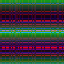

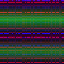

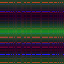

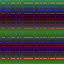

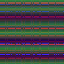

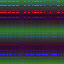

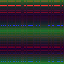

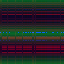

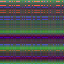

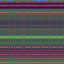

In [8]:
for i in range(0, 10):
    show_imp = array_to_img(X_train[i, ])
    display(show_imp)

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [9]:
image_size = 64
num_labels = 99
num_channels = 3 # grayscale
batch_size = 32
lamb_reg = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_val)
   # tf_test_dataset = tf.constant(test_image_data)

    # Variables.
    layer1_weights = weight_variable([3, 3, 3, 64])
    layer1_biases = bias_variable([64])
    layer2_weights = weight_variable([3, 3, 64, 128])
    layer2_biases = bias_variable([128])
    layer3_weights = weight_variable([3, 3, 128, 256])
    layer3_biases = bias_variable([256])
    layer4_weights = weight_variable([8*8*256, 1024])
    layer4_biases = bias_variable([1024])
    layer5_weights = weight_variable([1024, 1024])
    layer5_biases = bias_variable([1024])
    layer6_weights = weight_variable([1024, num_labels])
    layer6_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        # Max pooling
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm1 = tf.nn.lrn(pooled1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm1 = tf.nn.dropout(norm1, proba)
        
        # Convolution
        conv2 = tf.nn.conv2d(norm1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        # Max pooling
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm2 = tf.nn.lrn(pooled2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm2 = tf.nn.dropout(norm2, proba)
        
        # Convolution
        conv3 = tf.nn.conv2d(norm2, layer3_weights, [1, 1, 1, 1], padding='SAME') + layer3_biases
        # Max pooling
        pooled3 = tf.nn.max_pool(tf.nn.relu(conv3), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm3 = tf.nn.lrn(pooled3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm3 = tf.nn.dropout(norm3, proba)
        
        # Fully Connected Layer
        shape = layer4_weights.get_shape().as_list()
        reshape = tf.reshape(norm3, [-1, shape[0]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        full3 = tf.nn.relu(tf.matmul(full3, layer5_weights) + layer5_biases)

        return tf.matmul(full3, layer6_weights) + layer6_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) + \
                    tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + \
                    tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))

    # Add the regularization term to the loss.
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    # test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [ ]:
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), y_val)))
        # test_preds = test_prediction.eval().ravel()
        

In [ ]:
run_session(10001, "AlexNet", )

Instructions for updating:
Please switch to tf.summary.merge_all.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at epoch 0: 5.307634353637695
Minibatch accuracy: 3.1
Validation accuracy: 1.0
Minibatch loss at epoch 500: 1.4139553308486938
Minibatch accuracy: 65.6
Validation accuracy: 45.5
Minibatch loss at epoch 1000: 0.4025072455406189
Minibatch accuracy: 93.8
Validation accuracy: 57.6
Minibatch loss at epoch 1500: 0.17330504953861237
Minibatch accuracy: 100.0
Validation accuracy: 61.6
